In [1]:
# 移除警告語
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 使用主題模型分析英文論文資料
### 資料載入
+ 文本資料描述
### 資料前處理
+ 斷詞引擎設定（匯入字典）
+ 移除停用字
### LDA 主題模型
+ 利用 DTM 訓練LDA模型
+ 查看 LDA 主題代表字
+ 建立更多主題的主題模型
+ 透過指標找出最佳主題數
### 視覺化
+ 產生 LDAvis 結果、存檔
+ 查看 Document 主題分佈

In [2]:
import gensim
import numpy as np
import pandas as pd# pip install pandas

## 文本資料
+ 來源：NeurIPS會議上發表的論文集
+ 時間：2010年到2016年，隨機抽樣1000篇。
+ 關鍵字：機器學習相關主題

In [3]:
# 匯入資料
raw_data = pd.read_csv('./data/papers.csv')
# random_staste 隨機的狀態
raw_data = raw_data[ raw_data['year'] >= 2010 ] #2707
metadata = raw_data.sample(n=1000, random_state=2021).reset_index(drop=True)

In [4]:
year_count = pd.DataFrame({
    'year': metadata.groupby('year').size().index,
    'count': metadata.groupby('year').size().values
})
year_count = year_count.sort_values(by='year') # 排序

In [5]:
# 設定圖的字體
import matplotlib.pyplot as plt
import matplotlib
font = {'size':14}
matplotlib.rc('font', **font)

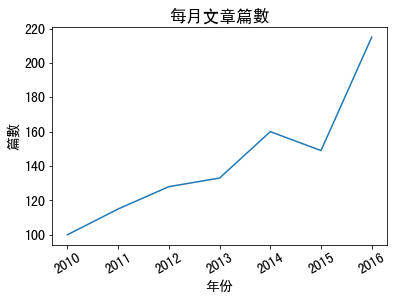

In [6]:
plt.plot(year_count['year'], year_count['count'])
plt.title('每月文章篇數') # 標題
plt.xlabel('年份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30) # 旋轉x刻度避免重疊
plt.show()

### 斷詞引擎設定：使用 NLTK 當作斷詞系統

In [7]:
import nltk
data = metadata[['title','paper_text']]

In [12]:
token_df = data.assign(wordlist = data['paper_text'].apply(nltk.word_tokenize))
token_df.head(3)
# 44s

,title,paper_text,wordlist
0,Random function priors for exchangeable arrays...,Random function priors for exchangeable arrays...,"[Random, function, priors, for, exchangeable, ..."
1,Linear Convergence with Condition Number Indep...,Linear Convergence with Condition Number\nInde...,"[Linear, Convergence, with, Condition, Number,..."
2,On the Analysis of Multi-Channel Neural Spike ...,On the Analysis of Multi-Channel Neural Spike ...,"[On, the, Analysis, of, Multi-Channel, Neural,..."


### 清除停用字、標點符號

In [13]:
from nltk.corpus import stopwords
# nltk.download('stopwords')

# nltk的stop_words
stop_words = []
stop_words = stopwords.words('english') 

# print(stop_words)

In [14]:
import re
def remove(listt):
    result = [re.sub(r'[^\w\s]|\d|_', '', word) for word in listt] #移除標點符號
    result = list(filter(lambda x : len(x)>1, result)) #避免只有單個英文字
    result = [word.lower() for word in result] #將所有字轉為小寫
    result = [word for word in result if not word in stop_words] #移除停用字
    
    # 簡易lemma
    lem = nltk.stem.WordNetLemmatizer()
    lemma_text = []
    for word in result:
        lemma = lem.lemmatize(word,'v')
        if lemma == word:
            lemma = lem.lemmatize(word,'n')
            if lemma == word:
                lemma = lem.lemmatize(word, 'a')
                lemma_text.append(lemma)
            else:
                lemma_text.append(lemma)
        else:
            lemma_text.append(lemma)

    return lemma_text

In [15]:
# 套用上面function
token_df = token_df.assign( remove_stopwords = token_df['wordlist'].apply(remove))
token_df.head(3)

,title,paper_text,wordlist,remove_stopwords
0,Random function priors for exchangeable arrays...,Random function priors for exchangeable arrays...,"[Random, function, priors, for, exchangeable, ...","[random, function, prior, exchangeable, array,..."
1,Linear Convergence with Condition Number Indep...,Linear Convergence with Condition Number\nInde...,"[Linear, Convergence, with, Condition, Number,...","[linear, convergence, condition, number, indep..."
2,On the Analysis of Multi-Channel Neural Spike ...,On the Analysis of Multi-Channel Neural Spike ...,"[On, the, Analysis, of, Multi-Channel, Neural,...","[analysis, multichannel, neural, spike, data, ..."


In [16]:
from gensim import corpora
token_data = token_df['remove_stopwords'].tolist()

In [17]:
# 創建語料(corpus)的詞語詞典，每個詞都被賦予一個索引（word_id，word_frequency）
id2word = corpora.Dictionary(token_data)

In [18]:
# 將詞典轉換文檔列表（語料）變成 Document Term Matrix
corpus = [id2word.doc2bow(text) for text in token_data]

In [19]:
# 語料庫(corpus)是（word_id，word_frequency）的對映。
id2word.doc2bow(['science','teacher'])

[(614, 1), (5980, 1)]

## 利用 DTM 訓練 LDA 模型

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus, # DTM
    id2word=id2word, # 字典
    num_topics=40, # 代表生成幾個主題數
    random_state=2021, # 亂數
    passes=5, # mini-batch 訓練次數
    iterations = 1000 # 收斂迭代
    # alpha='auto',
    # per_word_topics=True
)

# 1分鐘內跑完

## 查看LDA模型中的主題關鍵字

In [39]:
# 每個主題重要的前五個關鍵字
topics = ldamodel.print_topics(num_words=6)
for topic in topics[0:3]:
    #print(topic)

    # 整理成方便閱讀
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], listItems[0], sep='')

19:
  "model" 0.015
  "use"  0.013
  "learn"  0.012
  "network"  0.010
  "data"  0.008
  "latent" 0.007
24:
  "worker" 0.028
  "task"  0.015
  "algorithm"  0.014
  "label"  0.014
  "model"  0.010
  "use" 0.008
27:
  "point" 0.000
  "curve"  0.000
  "image"  0.000
  "classifier"  0.000
  "roc"  0.000
  "score" 0.000


### 猜測可能主題
+ 主題十六：有關圖像辨識的訓練模型
+ 主題十九：圖像辨識模型對未來的影響
+ 主題一：模型使用的樣本相關、STDP

## LDA 模型指標
+ Pairwise Pointwise Mutual Information : 主題連貫性 (越大越好)
+ perplexity score : 複雜度（越小越好）

In [22]:
from gensim.models import CoherenceModel

PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('PMI score: ', PMI_lda)

PMI score:  -0.16570385059320608


In [23]:
perplexity = ldamodel.log_perplexity(corpus)
print('Perplexity Score: ', perplexity)

Perplexity Score:  -7.882956391433594


## 尋找最佳主題數
+ 透過建立多個主題數的模型，以perplexity為指標

In [24]:
topic_num_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num,
        id2word=id2word,
        random_state = 100,
        passes=5,
        iterations=1000
    )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    
    result.append({"topic_num": topic_num, "perplexity": tmp_perplexity})

# 50分種跑完

### 把指標改為 dataframe 形式，並用折線圖表示

In [25]:
result = pd.DataFrame(result)
result

,topic_num,perplexity
0,5,-7.936171
1,10,-7.895437
2,15,-7.879942
3,20,-7.874215
4,25,-7.869718
5,30,-7.870912
6,35,-7.871401
7,40,-7.878935
8,45,-7.874048
9,50,-7.875497


<AxesSubplot:xlabel='topic_num'>

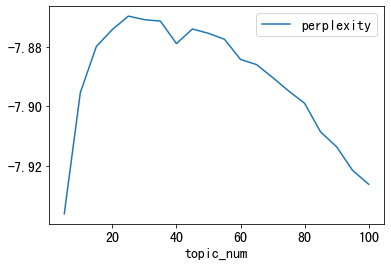

In [26]:
result.plot.line(x='topic_num', y='perplexity', label='perplexity')

## LDAvis 視覺化呈現

In [27]:
import pyLDAvis.gensim_models
ldaVis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary=ldamodel.id2word)
pyLDAvis.save_html(ldaVis,'./lda_result/ldaVis_en.html')

/Users/changfangyu/opt/anaconda3/envs/fanny_nltk/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# Document 主題分佈

In [28]:
# 取得每條新聞的主題分佈
topics_doc = ldamodel.get_document_topics(corpus)  

# 將結果列成list
doc_list = []

# topics_doc[i] 為第一個文章
for i in range(0,len(topics_doc)):

    # 都先假定第一個主題為最大的
    max_freq = topics_doc[i][0][1]
    max_topic = topics_doc[i][0][0]

    # 後面假如有比較大的就取代
    for j in topics_doc[i]:
        if(j[1] > max_freq):
            max_freq = j[1]
            max_topic = j[0]

    # print(max_topic)
    # print(max_freq)
    doc_list.append(max_topic)

In [29]:
# 將結果放進 DataFrame裏
metadata['topic'] = doc_list

In [30]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':metadata.groupby(['year','topic']).size()
})

date_topic = date_topic.reset_index()

In [31]:
date_df = date_topic.pivot_table(index='year', values='count', columns='topic').fillna(0).reset_index()
date_df

topic,year,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,2010,4.0,3.0,0.0,3.0,0.0,1.0,4.0,8.0,2.0,...,0.0,4.0,2.0,0.0,1.0,3.0,0.0,4.0,2.0,3.0
1,2011,7.0,6.0,3.0,5.0,1.0,2.0,4.0,1.0,4.0,...,1.0,9.0,1.0,0.0,0.0,2.0,1.0,3.0,5.0,3.0
2,2012,7.0,6.0,3.0,3.0,1.0,1.0,5.0,10.0,1.0,...,3.0,6.0,1.0,2.0,0.0,0.0,1.0,3.0,2.0,0.0
3,2013,6.0,3.0,2.0,2.0,1.0,2.0,9.0,1.0,4.0,...,2.0,4.0,1.0,0.0,2.0,1.0,0.0,7.0,10.0,5.0
4,2014,8.0,5.0,6.0,7.0,5.0,1.0,7.0,5.0,3.0,...,0.0,3.0,2.0,5.0,2.0,6.0,6.0,6.0,6.0,3.0
5,2015,13.0,8.0,5.0,9.0,2.0,1.0,2.0,2.0,4.0,...,1.0,6.0,3.0,1.0,4.0,4.0,4.0,6.0,3.0,2.0
6,2016,9.0,13.0,2.0,7.0,2.0,0.0,6.0,4.0,6.0,...,5.0,5.0,5.0,6.0,4.0,7.0,2.0,4.0,9.0,6.0


## 可以看到在不同時間點，特定主題談論的篇幅多寡

In [32]:
# 提前幾個為例
name = date_df.columns.tolist()[:6]
date_df_example = date_df[name]
date_df_example

topic,year,0,1,2,3,4
0,2010,4.0,3.0,0.0,3.0,0.0
1,2011,7.0,6.0,3.0,5.0,1.0
2,2012,7.0,6.0,3.0,3.0,1.0
3,2013,6.0,3.0,2.0,2.0,1.0
4,2014,8.0,5.0,6.0,7.0,5.0
5,2015,13.0,8.0,5.0,9.0,2.0
6,2016,9.0,13.0,2.0,7.0,2.0


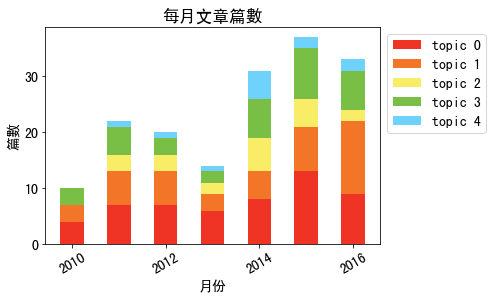

In [33]:
plt.bar(date_df.year, date_df_example[0] ,color="#EF3324",label="topic 0", width=0.5) #主題一
plt.bar(date_df.year, date_df_example[1], color="#F37527", bottom=date_df_example[0],label="topic 1" , width=0.5) #主題二
plt.bar(date_df.year, date_df_example[2] ,color="#F9EC66", bottom=date_df_example[1] + date_df_example[0] , label="topic 2", width=0.5) #主題三
plt.bar(date_df.year, date_df_example[3], color="#79BF46", bottom=date_df_example[0] + date_df_example[1] + date_df_example[2], label="topic 3", width=0.5) #主題四
plt.bar(date_df.year, date_df_example[4], color="#6FD2FA", bottom=date_df_example[0] + date_df_example[1] + date_df_example[2] + date_df_example[3], label="topic 4", width=0.5) #主題五

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

## 以比例來看

In [34]:
ratio_df = date_df_example.copy()
ratio_df['sum'] = ratio_df[0] + ratio_df[1] + ratio_df[2] + ratio_df[3] + ratio_df[4]
ratio_df[0] = ratio_df[0] / ratio_df['sum']
ratio_df[1] = ratio_df[1] / ratio_df['sum']
ratio_df[2] = ratio_df[2] / ratio_df['sum']
ratio_df[3] = ratio_df[3] / ratio_df['sum']
ratio_df[4] = ratio_df[4] / ratio_df['sum']

ratio_df

topic,year,0,1,2,3,4,sum
0,2010,0.400000,0.300000,0.000000,0.300000,0.000000,10.0
1,2011,0.318182,0.272727,0.136364,0.227273,0.045455,22.0
2,2012,0.350000,0.300000,0.150000,0.150000,0.050000,20.0
3,2013,0.428571,0.214286,0.142857,0.142857,0.071429,14.0
4,2014,0.258065,0.161290,0.193548,0.225806,0.161290,31.0
5,2015,0.351351,0.216216,0.135135,0.243243,0.054054,37.0
6,2016,0.272727,0.393939,0.060606,0.212121,0.060606,33.0


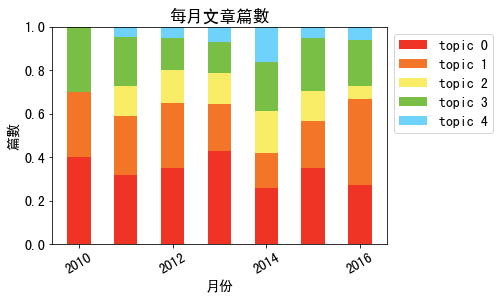

In [35]:
plt.bar(date_df.year, ratio_df[0] ,color="#EF3324",label="topic 0", width=0.5) #主題一
plt.bar(date_df.year, ratio_df[1], color="#F37527", bottom=ratio_df[0],label="topic 1" , width=0.5) #主題二
plt.bar(date_df.year, ratio_df[2] ,color="#F9EC66", bottom=ratio_df[1] + ratio_df[0] , label="topic 2", width=0.5) #主題三
plt.bar(date_df.year, ratio_df[3], color="#79BF46", bottom=ratio_df[0] + ratio_df[1] + ratio_df[2], label="topic 3", width=0.5) #主題四
plt.bar(date_df.year, ratio_df[4], color="#6FD2FA", bottom=ratio_df[0] + ratio_df[1] + ratio_df[2] + ratio_df[3], label="topic 4", width=0.5) #主題五

plt.title('每月文章篇數') # 標題
plt.xlabel('月份') # x軸標題
plt.ylabel('篇數') # y軸標題
plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

##  隨機看一下不同主題大概都在談論什麼

In [36]:
## 主題一
metadata[metadata['topic'] == 0].sample(n=5)

,id,year,title,event_type,pdf_name,abstract,paper_text,topic
989,4468,2011,Inferring spike-timing-dependent plasticity fr...,NaN,4468-inferring-spike-timing-dependent-plastici...,Synaptic plasticity underlies learning and is ...,Inferring spike-timing-dependent plasticity fr...,0
992,5543,2014,Unsupervised learning of an efficient short-te...,Spotlight,5543-unsupervised-learning-of-an-efficient-sho...,Learning in recurrent neural networks has been...,Unsupervised learning of an efficient short-te...,0
116,4458,2011,Simultaneous Sampling and Multi-Structure Fitt...,NaN,4458-simultaneous-sampling-and-multi-structure...,Multi-structure model fitting has traditionall...,Simultaneous Sampling and Multi-Structure Fitt...,0
140,4690,2012,Towards a learning-theoretic analysis of spike...,NaN,4690-towards-a-learning-theoretic-analysis-of-...,This paper suggests a learning-theoretic persp...,Towards a learning-theoretic analysis of\nspik...,0
206,4172,2010,Switching state space model for simultaneously...,NaN,4172-switching-state-space-model-for-simultane...,We propose an algorithm for simultaneously est...,000\n001\n002\n003\n004\n005\n006\n007\n\nSwit...,0


In [37]:
## 主題二
metadata[metadata['topic'] == 1].sample(n=5)

,id,year,title,event_type,pdf_name,abstract,paper_text,topic
182,5679,2015,Learning with a Wasserstein Loss,Poster,5679-learning-with-a-wasserstein-loss.pdf,Learning to predict multi-label outputs is cha...,Learning with a Wasserstein Loss\nCharlie Frog...,1
186,6553,2016,Adaptive Averaging in Accelerated Descent Dyna...,Poster,6553-adaptive-averaging-in-accelerated-descent...,We study accelerated descent dynamics for cons...,Adaptive Averaging in Accelerated Descent Dyna...,1
649,6100,2016,Active Nearest-Neighbor Learning in Metric Spaces,Poster,6100-active-nearest-neighbor-learning-in-metri...,We propose a pool-based non-parametric active ...,Active Nearest-Neighbor Learning in Metric Spa...,1
253,5811,2015,Sample Complexity of Learning Mahalanobis Dist...,Poster,5811-sample-complexity-of-learning-mahalanobis...,Metric learning seeks a transformation of the ...,Sample Complexity of Learning Mahalanobis\nDis...,1
469,6156,2016,beta-risk: a New Surrogate Risk for Learning f...,Poster,6156-beta-risk-a-new-surrogate-risk-for-learni...,"During the past few years, the machine learnin...",?-risk: a New Surrogate Risk for Learning\nfro...,1


In [38]:
## 主題三
metadata[metadata['topic'] == 2].sample(n=5)

,id,year,title,event_type,pdf_name,abstract,paper_text,topic
555,5937,2015,Logarithmic Time Online Multiclass prediction,Spotlight,5937-logarithmic-time-online-multiclass-predic...,We study the problem of multiclass classificat...,Logarithmic Time Online Multiclass prediction\...,2
963,4249,2011,Learning to Agglomerate Superpixel Hierarchies,NaN,4249-learning-to-agglomerate-superpixel-hierar...,An agglomerative clustering algorithm merges t...,Learning to Agglomerate Superpixel Hierarchies...,2
73,4520,2012,Mandatory Leaf Node Prediction in Hierarchical...,NaN,4520-mandatory-leaf-node-prediction-in-hierarc...,"In hierarchical classification, the prediction...",Mandatory Leaf Node Prediction in\nHierarchica...,2
608,4382,2011,A Collaborative Mechanism for Crowdsourcing Pr...,NaN,4382-a-collaborative-mechanism-for-crowdsourci...,Machine Learning competitions such as the Netf...,A Collaborative Mechanism for Crowdsourcing\nP...,2
209,4228,2011,Probabilistic Joint Image Segmentation and Lab...,NaN,4228-probabilistic-joint-image-segmentation-an...,We present a joint image segmentation and labe...,Probabilistic Joint Image Segmentation and Lab...,2
